In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv
import cv2
from PIL import Image

In [14]:
model = xrv.baseline_models.chestx_det.PSPNet()

In [15]:
model

chestx-det-pspnet

In [ ]:
# Path to the source image (keep this so we can reference the original later)
image_path = "../../../torchxrayvision-main/images/00000040_001.png"
# Load original image (uint8) for display and later resizing
orig_img_np = skimage.io.imread(image_path)
# Normalize a working copy for the model
img = xrv.datasets.normalize(orig_img_np, 255) # convert 8-bit image to [-1024, 1024] range
if img.ndim == 3:
    img = img.mean(2)[None, ...] # Make single color channel
else:
    img = img[None, ...] # Already single channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(512)])

img = transform(img)
img = torch.from_numpy(img).float() # Ensure tensor is float32
img = img.unsqueeze(0) # Add batch dimension

In [17]:
with torch.no_grad():
    pred = model(img)

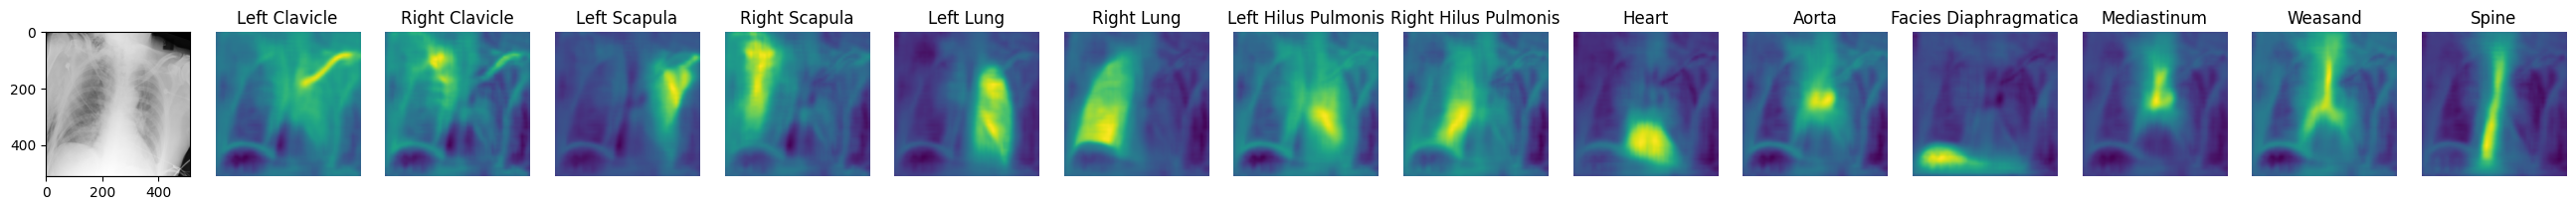

In [18]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(model.targets) + 1, 1)
# Prepare image for display (convert to numpy and squeeze channel if necessary)
if isinstance(img, torch.Tensor):
    img_disp = img[0].cpu().numpy()
else:
    img_disp = np.array(img[0])
# img_disp could be (1,H,W) or (H,W,1); squeeze to (H,W)
if img_disp.ndim == 3:
    # common channel-first (1,H,W)
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
    # channel-last (H,W,1)
    elif img_disp.shape[2] == 1:
        img_disp = img_disp[:,:,0]
plt.imshow(img_disp, cmap='gray')
for i in range(len(model.targets)):
    plt.subplot(1, len(model.targets) + 1, i+2)
    # Convert prediction to numpy if it's a torch tensor
    if isinstance(pred, torch.Tensor):
        pred_disp = pred[0, i].cpu().numpy()
    else:
        pred_disp = np.array(pred[0, i])
    plt.imshow(pred_disp)
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

In [19]:
pred = 1 / (1 + np.exp(-pred))  # sigmoid
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1

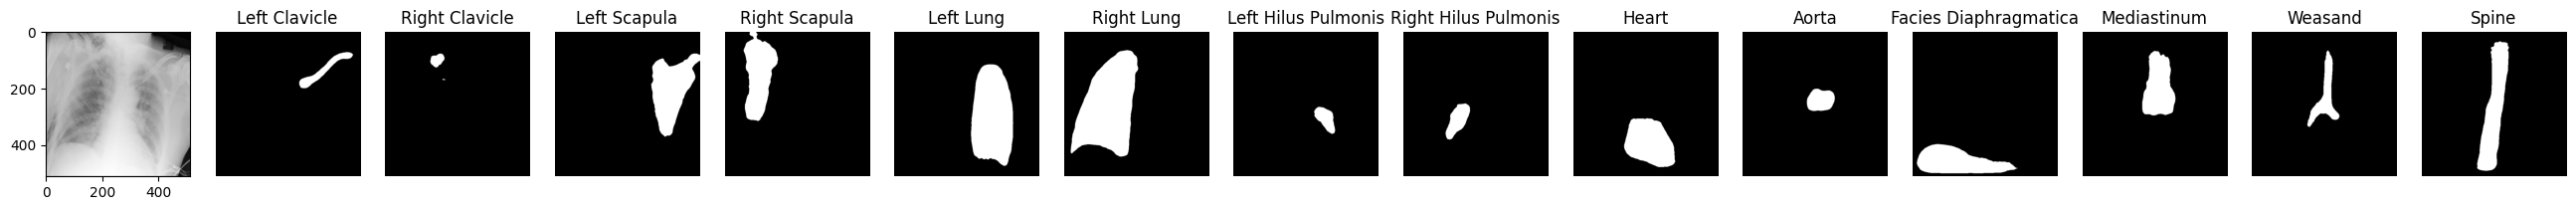

In [20]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(model.targets) + 1, 1)
# Convert and squeeze image for display
if isinstance(img, torch.Tensor):
    img_disp = img[0].cpu().numpy()
else:
    img_disp = np.array(img[0])
if img_disp.ndim == 3:
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
    elif img_disp.shape[2] == 1:
        img_disp = img_disp[:,:,0]
plt.imshow(img_disp, cmap='gray')
for i in range(len(model.targets)):
    plt.subplot(1, len(model.targets) + 1, i+2)
    if isinstance(pred, torch.Tensor):
        pred_disp = pred[0, i].cpu().numpy()
    else:
        pred_disp = np.array(pred[0, i])
    plt.imshow(pred_disp, cmap='gray')
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

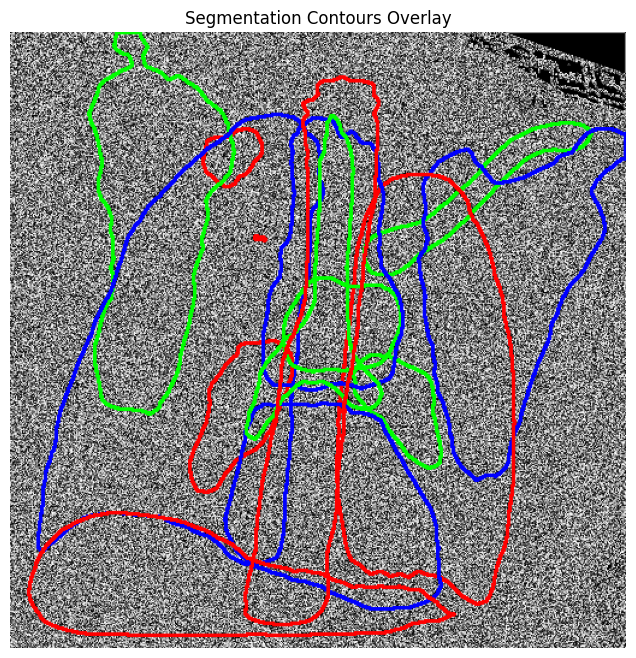

In [22]:
# ==========================================
# 6️⃣ Draw Contours Overlay
# ==========================================
# Convert grayscale image to RGB
img_rgb = cv2.cvtColor((img_disp * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Get predicted masks
pred_np = pred[0].cpu().numpy()

# Colors for each target (BGR for cv2)
colors = [(0,255,0), (255,0,0), (0,0,255)]  # lungs, heart, clavicles

# Draw contours
for i, target in enumerate(model.targets):
    mask = (pred_np[i] > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_rgb, contours, -1, colors[i % len(colors)], 2)

plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.title("Segmentation Contours Overlay")
plt.axis("off")
plt.show()


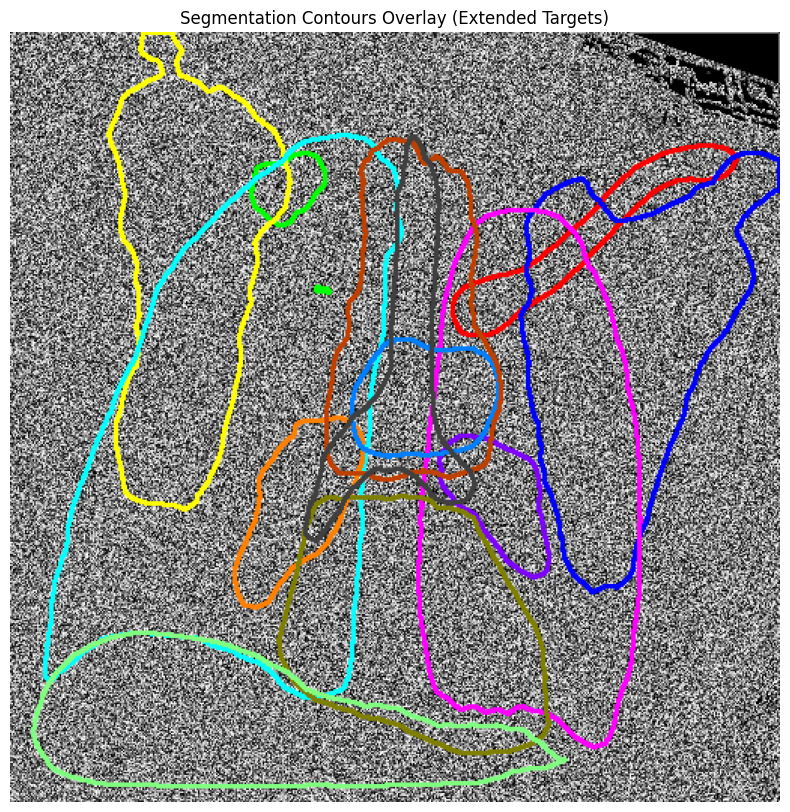

In [23]:
# ==========================================
# 6️⃣ Draw Contours Overlay (Extended Targets)
# ==========================================

# Convert grayscale image to RGB
img_rgb = cv2.cvtColor((img_disp * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Get predicted masks
pred_np = pred[0].cpu().numpy()

# Define extended anatomical targets and colors
extended_targets = [
    "left_clavicle", "right_clavicle",
    "left_scapula", "right_scapula",
    "right_lung",
    "left_hilus_pulmonis", "right_hilus_pulmonis",
    "heart", "aorta",
    "facies_diaphragmatica",
    "mediastinum", "weasand", "spine"
]

# 13 distinct RGB colors
colors = [
    (255, 0, 0),      # left clavicle – red
    (0, 255, 0),      # right clavicle – green
    (0, 0, 255),      # left scapula – blue
    (255, 255, 0),    # right scapula – yellow
    (255, 0, 255),    # right lung – magenta
    (0, 255, 255),    # left hilus pulmonis – cyan
    (128, 0, 255),    # right hilus pulmonis – purple
    (255, 128, 0),    # heart – orange
    (128, 128, 0),    # aorta – olive
    (0, 128, 255),    # facies diaphragmatica – sky blue
    (128, 255, 128),  # mediastinum – light green
    (192, 64, 0),     # weasand – brown
    (64, 64, 64)      # spine – gray
]

# Make sure we don’t exceed model channels
num_channels = min(pred_np.shape[0], len(extended_targets))

# Draw contours for each detected mask
for i in range(num_channels):
    mask = (pred_np[i] > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_rgb, contours, -1, colors[i % len(colors)], 2)

# Display result
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.title("Segmentation Contours Overlay (Extended Targets)")
plt.axis("off")
plt.show()


In [ ]:
# ==========================================
# 6️⃣ Draw Contours Overlay on Original Image
# ==========================================
from PIL import Image  # ✅ make sure this is included

# 1️⃣ We already loaded the original full-size image as orig_img_np earlier
# orig_img_np is a uint8 grayscale array
# Convert to RGB for contour drawing
img_rgb = cv2.cvtColor(orig_img_np, cv2.COLOR_GRAY2RGB)

# 2️⃣ Get predicted masks from model output (C, H, W) or (1, C, H, W) depending on model
pred_np = pred[0].cpu().numpy()  # shape: (C, H, W)

# 3️⃣ Define anatomical targets and colors
extended_targets = [
    "left_clavicle", "right_clavicle",
    "left_scapula", "right_scapula",
    "right_lung",
    "left_hilus_pulmonis", "right_hilus_pulmonis",
    "heart", "aorta",
    "facies_diaphragmatica",
    "mediastinum", "weasand", "spine"
],
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
    (255, 0, 255), (0, 255, 255), (128, 0, 255), (255, 128, 0),
    (128, 128, 0), (0, 128, 255), (128, 255, 128), (192, 64, 0), (64, 64, 64),
]

# Limit channels to available predictions
num_channels = min(pred_np.shape[0], len(extended_targets))

# 4️⃣ Resize each mask back to original image size
H, W = orig_img_np.shape[:2]

for i in range(num_channels):
    # pred_np[i] is in model output resolution (e.g., 512x512). Resize to original image size (W,H)
    mask_resized = cv2.resize(pred_np[i], (W, H))  # note cv2 resize expects (width, height)
    mask_binary = (mask_resized > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_rgb, contours, -1, colors[i % len(colors)], 2)

# 5️⃣ Show overlay on real image
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.title("Segmentation Contours Overlay (Original Image)")
plt.axis("off")
plt.show()


AttributeError: 'Tensor' object has no attribute 'read'